### AI Bootcamp - June 2024 Cohort - Analyzing and Predicting Flight Delays
Documentation and Context: See the project's ReadMe.md file for documentation on the column names and purposes.

### What's in this workbook?
This is a starter Jupyter Notebook for the project team to use when building out various machine learning models. Each team member will create a copy of this notebook for their work. 

## Libraries Imported
* Pandas
* Numpy
* Matplotlib
* sklearn
    * StandardScaler
    * PCA
    * LabelEncoder

In [83]:
# Do imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# Import Gradient Boosting classifier
from sklearn.ensemble import GradientBoostingClassifier
# Import an Adaptive Boosting classifier
from sklearn.ensemble import AdaBoostClassifier
# Import xgboost
import xgboost as xgb



In [84]:
# Install xgboost
!pip install xgboost

### Read In Data to Dataframe

In [85]:
# Create DataFrame
df = pd.read_csv('./data/Airlines.csv')
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [86]:
df.describe()

,id,Flight,DayOfWeek,Time,Length,Delay
count,539383.00000,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,269692.00000,2427.928630,3.929668,802.728963,132.202007,0.445442
std,155706.60446,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.00000,1.000000,1.000000,10.000000,0.000000,0.000000
25%,134846.50000,712.000000,2.000000,565.000000,81.000000,0.000000
50%,269692.00000,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,404537.50000,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,539383.00000,7814.000000,7.000000,1439.000000,655.000000,1.000000


In [87]:
len(df['AirportFrom'].unique())

293

In [88]:
# Encode the Length as hours and rename it to make it clearer what it is
df['Flight_Length_Hours'] = df['Length'] / 60

In [89]:
# Encode the Time column as hours and rename it to make it clear what it is
df['Departure_Time_Hour'] = df['Time'] / 60

In [90]:
# Drop the Time and Length columns since we don't need these for our features
df.drop(columns=['Length', 'Time'], inplace=True)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   539383 non-null  int64  
 1   Airline              539383 non-null  object 
 2   Flight               539383 non-null  int64  
 3   AirportFrom          539383 non-null  object 
 4   AirportTo            539383 non-null  object 
 5   DayOfWeek            539383 non-null  int64  
 6   Delay                539383 non-null  int64  
 7   Flight_Length_Hours  539383 non-null  float64
 8   Departure_Time_Hour  539383 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 37.0+ MB


### Preprocessing: Encoding 'AirportFrom', 'AirportTo', 'Airline' Columns

In [92]:
airport_codes = df['AirportFrom'].unique()
airport_codes

array(['SFO', 'PHX', 'LAX', 'ANC', 'LAS', 'SLC', 'DEN', 'ONT', 'FAI',
       'BQN', 'PSE', 'HNL', 'BIS', 'IYK', 'EWR', 'BOS', 'MKE', 'GFK',
       'OMA', 'GSO', 'LMT', 'SEA', 'MCO', 'TPA', 'DLH', 'MSP', 'FAR',
       'MFE', 'MSY', 'VPS', 'BWI', 'MAF', 'LWS', 'RST', 'ALB', 'DSM',
       'CHS', 'MSN', 'JAX', 'SAT', 'PNS', 'BHM', 'LIT', 'SAV', 'BNA',
       'ICT', 'ECP', 'DHN', 'MGM', 'CAE', 'PWM', 'ACV', 'EKO', 'PHL',
       'ATL', 'PDX', 'RIC', 'BTR', 'HRL', 'MYR', 'TUS', 'SBN', 'CAK',
       'TVC', 'CLE', 'ORD', 'DAY', 'MFR', 'BTV', 'TLH', 'TYS', 'DFW',
       'FLL', 'AUS', 'CHA', 'CMH', 'LRD', 'BRO', 'CRP', 'LAN', 'PVD',
       'FWA', 'JFK', 'LGA', 'OKC', 'PIT', 'PBI', 'ORF', 'DCA', 'AEX',
       'SYR', 'SHV', 'VLD', 'BDL', 'FAT', 'BZN', 'RDM', 'LFT', 'IPL',
       'EAU', 'ERI', 'BUF', 'IAH', 'MCI', 'AGS', 'ABI', 'GRR', 'LBB',
       'CLT', 'LEX', 'MBS', 'MOD', 'AMA', 'SGF', 'AZO', 'ABE', 'SWF',
       'BGM', 'AVP', 'FNT', 'GSP', 'ATW', 'ITH', 'TUL', 'COS', 'ELP',
       'ABQ', 'SMF',

### Make a copy of the DataFrame for preprocessing

In [93]:
encoded_df = df.copy()

In [94]:
unique_codes = encoded_df['AirportFrom'].unique()
code_to_id = {code: idx for idx, code in enumerate(unique_codes, start=1)}

# Apply the mapping to create a new column with unique IDs
encoded_df['AirportFromIDs'] = encoded_df['AirportFrom'].map(code_to_id)
encoded_df['AirportToIDs'] = encoded_df['AirportTo'].map(code_to_id)

encoded_df

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Delay,Flight_Length_Hours,Departure_Time_Hour,AirportFromIDs,AirportToIDs
0,1,CO,269,SFO,IAH,3,1,3.416667,0.250000,1,103
1,2,US,1558,PHX,CLT,3,1,3.700000,0.250000,2,109
2,3,AA,2400,LAX,DFW,3,1,2.750000,0.333333,3,72
3,4,AA,2466,SFO,DFW,3,1,3.250000,0.333333,1,72
4,5,AS,108,ANC,SEA,3,0,3.366667,0.500000,4,22
...,...,...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,0,5.433333,23.983333,194,229
539379,539380,FL,398,SEA,ATL,5,0,5.083333,23.983333,22,55
539380,539381,FL,609,SFO,MKE,5,0,4.250000,23.983333,1,17
539381,539382,UA,78,HNL,SFO,5,1,5.216667,23.983333,12,1


In [95]:
# Get unique airline codes
unique_airlines = encoded_df['Airline'].unique()

# Create a random mapping for each unique airline code
random.seed(42)  # Set a seed for reproducibility, remove if you want different random results each time
airline_to_id = {airline: random.randint(1000, 9999) for airline in unique_airlines}

# Apply the random mapping to the airline column
encoded_df['AirlineID'] = encoded_df['Airline'].map(airline_to_id)

encoded_df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Delay,Flight_Length_Hours,Departure_Time_Hour,AirportFromIDs,AirportToIDs,AirlineID
0,1,CO,269,SFO,IAH,3,1,3.416667,0.250000,1,103,2824
1,2,US,1558,PHX,CLT,3,1,3.700000,0.250000,2,109,1409
2,3,AA,2400,LAX,DFW,3,1,2.750000,0.333333,3,72,5506
3,4,AA,2466,SFO,DFW,3,1,3.250000,0.333333,1,72,5506
4,5,AS,108,ANC,SEA,3,0,3.366667,0.500000,4,22,5012


In [96]:
len(encoded_df["AirportFrom"].unique())

293

In [97]:
len(encoded_df["AirportTo"].unique())

293

In [98]:
# Drop all the categorical columns
encoded_df = encoded_df.drop(columns=['Airline', 'AirportFrom', 'AirportTo'])
encoded_df.head()

,id,Flight,DayOfWeek,Delay,Flight_Length_Hours,Departure_Time_Hour,AirportFromIDs,AirportToIDs,AirlineID
0,1,269,3,1,3.416667,0.250000,1,103,2824
1,2,1558,3,1,3.700000,0.250000,2,109,1409
2,3,2400,3,1,2.750000,0.333333,3,72,5506
3,4,2466,3,1,3.250000,0.333333,1,72,5506
4,5,108,3,0,3.366667,0.500000,4,22,5012


In [99]:
# Drop the id column since this is a hard-coded index
encoded_df = encoded_df.drop(columns=['id'])
encoded_df.head()

,Flight,DayOfWeek,Delay,Flight_Length_Hours,Departure_Time_Hour,AirportFromIDs,AirportToIDs,AirlineID
0,269,3,1,3.416667,0.250000,1,103,2824
1,1558,3,1,3.700000,0.250000,2,109,1409
2,2400,3,1,2.750000,0.333333,3,72,5506
3,2466,3,1,3.250000,0.333333,1,72,5506
4,108,3,0,3.366667,0.500000,4,22,5012


### Feature Engineering
After testing the models, we found we needed to do some control of our features to improve our accuracy

In [100]:
#0 --> Morning | 1 --> Afternoon | 2 --> Evening | 3 --> Night
departure_group = []
for i in range(0,len(df)):
    if ((encoded_df['Departure_Time_Hour'][i] >= 5) & (encoded_df['Departure_Time_Hour'][i] < 12)):      
        departure_group.append(0)
    elif ((encoded_df['Departure_Time_Hour'][i] >= 12) & (encoded_df['Departure_Time_Hour'][i] < 17)):    
        departure_group.append(1)
    elif ((encoded_df['Departure_Time_Hour'][i] >= 17) & (encoded_df['Departure_Time_Hour'][i] < 21)): 
        departure_group.append(2)
    else: 
        departure_group.append(3)

encoded_df['Departure_Group'] = departure_group

In [101]:
# Get counts
encoded_df['Departure_Group'].value_counts()

Departure_Group
0    223289
1    170239
2    120044
3     25811
Name: count, dtype: int64

In [102]:
# Group days into weekends (0 = weekday and 1 = weekend)
encoded_df['Weekend'] = encoded_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
encoded_df.head()

,Flight,DayOfWeek,Delay,Flight_Length_Hours,Departure_Time_Hour,AirportFromIDs,AirportToIDs,AirlineID,Departure_Group,Weekend
0,269,3,1,3.416667,0.250000,1,103,2824,3,0
1,1558,3,1,3.700000,0.250000,2,109,1409,3,0
2,2400,3,1,2.750000,0.333333,3,72,5506,3,0
3,2466,3,1,3.250000,0.333333,1,72,5506,3,0
4,108,3,0,3.366667,0.500000,4,22,5012,3,0


In [103]:
# Create a column for the hour the flight arrived at its destination after being delayed

arrival_time = []
for i in range(0,len(encoded_df)):     
    if ((encoded_df['Departure_Time_Hour'][i] + encoded_df['Flight_Length_Hours'][i]) >=24):
        arrival_time.append((encoded_df['Departure_Time_Hour'][i] + encoded_df['Flight_Length_Hours'][i])-24)
    else:
        arrival_time.append(encoded_df['Departure_Time_Hour'][i] + encoded_df['Flight_Length_Hours'][i])
        
encoded_df['Arrival_Time_Hour'] = arrival_time
encoded_df.head()

,Flight,DayOfWeek,Delay,Flight_Length_Hours,Departure_Time_Hour,AirportFromIDs,AirportToIDs,AirlineID,Departure_Group,Weekend,Arrival_Time_Hour
0,269,3,1,3.416667,0.250000,1,103,2824,3,0,3.666667
1,1558,3,1,3.700000,0.250000,2,109,1409,3,0,3.950000
2,2400,3,1,2.750000,0.333333,3,72,5506,3,0,3.083333
3,2466,3,1,3.250000,0.333333,1,72,5506,3,0,3.583333
4,108,3,0,3.366667,0.500000,4,22,5012,3,0,3.866667


In [104]:
# Group arrivals like we grouped departures, based on time of day
arrival_group = []
for i in range(0,len(df)):
    if ((encoded_df['Arrival_Time_Hour'][i] >= 5) & (encoded_df['Arrival_Time_Hour'][i] < 12)):      
        arrival_group.append(0)
    elif ((encoded_df['Arrival_Time_Hour'][i] >= 12) & (encoded_df['Arrival_Time_Hour'][i] < 17)):    
        arrival_group.append(1)
    elif ((encoded_df['Arrival_Time_Hour'][i] >= 17) & (encoded_df['Arrival_Time_Hour'][i] < 21)): 
        arrival_group.append(2)
    else: 
        arrival_group.append(3)
        
encoded_df['Arrival_Group'] = arrival_group

### Correlation

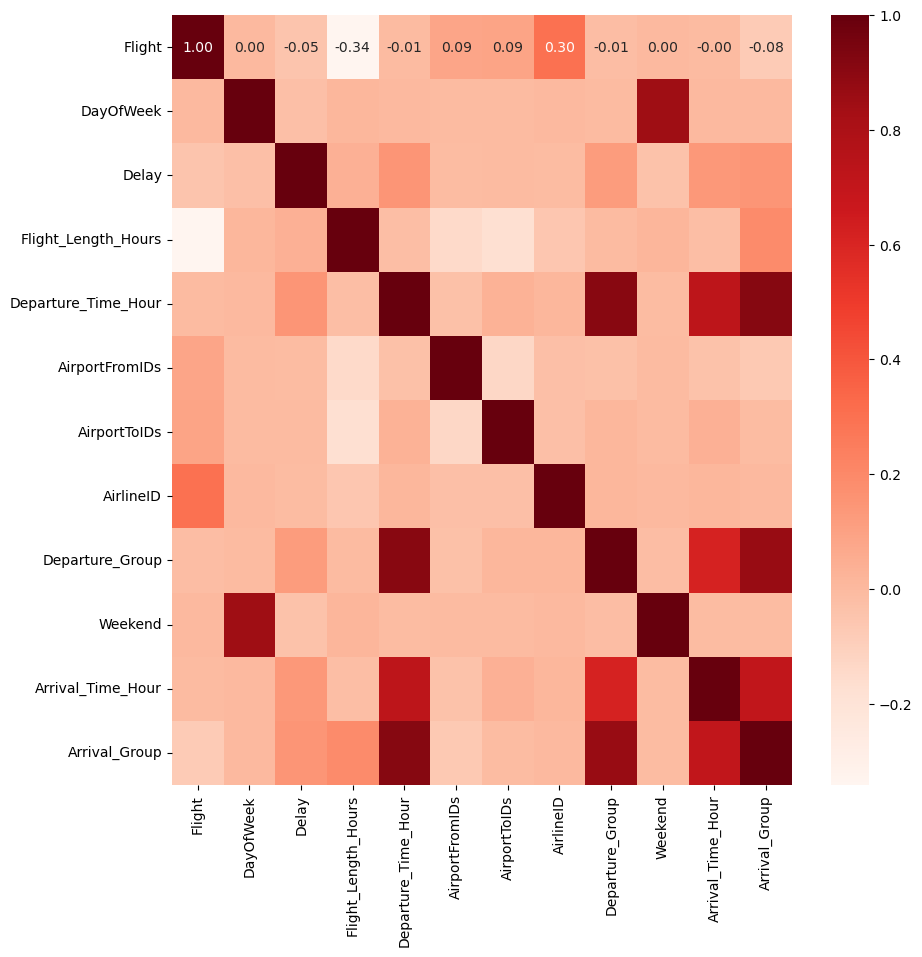

In [105]:
# Create a correlation matrix to see how features are related
plt.figure(figsize=(10,10))
cor = encoded_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, fmt='.2f')
plt.show()

### Prepare the data for modeling

In [106]:
# Define X for training and testing and drop the Delay column since it's our target
X = encoded_df.copy()
X.drop('Delay', axis=1, inplace=True)
X.head()

,Flight,DayOfWeek,Flight_Length_Hours,Departure_Time_Hour,AirportFromIDs,AirportToIDs,AirlineID,Departure_Group,Weekend,Arrival_Time_Hour,Arrival_Group
0,269,3,3.416667,0.250000,1,103,2824,3,0,3.666667,3
1,1558,3,3.700000,0.250000,2,109,1409,3,0,3.950000,3
2,2400,3,2.750000,0.333333,3,72,5506,3,0,3.083333,3
3,2466,3,3.250000,0.333333,1,72,5506,3,0,3.583333,3
4,108,3,3.366667,0.500000,4,22,5012,3,0,3.866667,3


In [107]:
# Define the Delay column as our target
y = df['Delay']

[1.15246853e+03 3.70486797e+02 8.85711795e+02 1.24923930e+04
 5.94373880e+01 8.04738613e+00 2.37551131e+01 8.06338514e+03
 6.46635625e+02 1.03828772e+04 1.22813224e+04]
Original shape: (539383, 11)
Selected shape: (539383, 7)


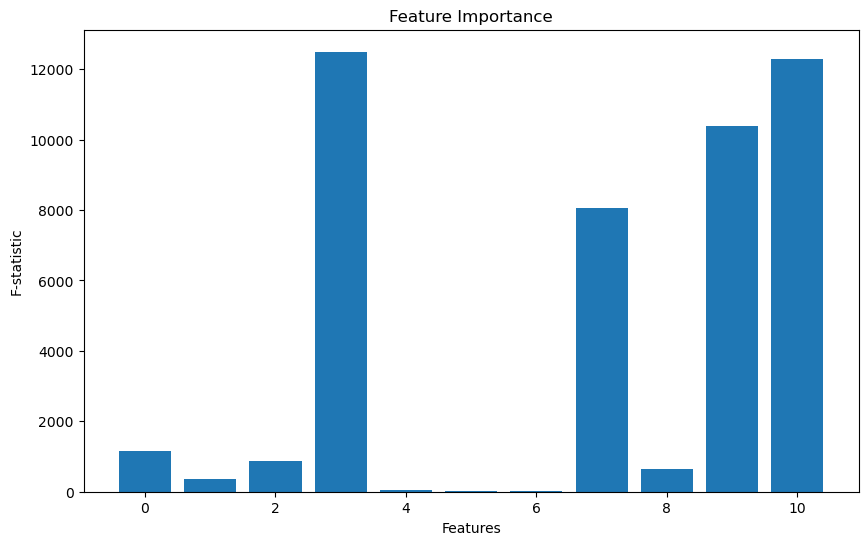

In [108]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=7)
X_selected = selector.fit_transform(X, y)

print(selector.scores_)
print("Original shape:", X.shape)
print("Selected shape:", X_selected.shape)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(len(selector.scores_)), selector.scores_)
plt.xlabel('Features')
plt.ylabel('F-statistic')
plt.title('Feature Importance')
plt.show()

In [109]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Scale the Data
SVM, KNN, K-Means, and PCA need scaling

In [110]:
# Scaling the X train data by using StandardScaler()
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[-1.09447296,  1.08199271, -1.40203345, ...,  1.23318561,
        -0.20030847, -0.28519086],
       [ 2.01121043, -1.00719177, -0.91656721, ..., -0.81090794,
         0.8465066 ,  0.68780661],
       [-0.8346985 ,  0.55969659,  1.89628129, ...,  1.23318561,
         0.23867849, -0.28519086],
       ...,
       [ 0.14828415, -1.00719177,  1.31086612, ..., -0.81090794,
        -0.76086106, -1.25818834],
       [ 1.46021769, -0.48489565, -0.77378302, ..., -0.81090794,
        -0.84865845, -1.25818834],
       [ 0.77038833, -0.48489565, -0.10269734, ..., -0.81090794,
        -0.1158879 , -0.28519086]])

In [111]:
# Scale X test data by using StandardScaler()
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[-1.13268931,  0.03740047,  0.56838834, ..., -0.81090794,
        -0.68319413, -1.25818834],
       [-0.45737249, -0.48489565,  0.53983151, ..., -0.81090794,
        -1.11205063, -1.25818834],
       [ 0.77232333,  0.55969659, -0.0741405 , ...,  1.23318561,
         0.59999853,  0.68780661],
       ...,
       [ 1.25752589, -1.52948788, -0.05986208, ..., -0.81090794,
        -1.3889501 , -1.25818834],
       [ 0.59527036,  1.60428882,  0.96818407, ...,  1.23318561,
         1.36991413,  1.66080408],
       [-0.66054803,  0.55969659,  1.25375245, ...,  1.23318561,
         0.3737514 , -0.28519086]])

### SVM

In [112]:
# Create the support vector machine classifier model
svc_model = SVC(kernel='poly', max_iter=10000)

In [113]:
svc_model.fit(X_train_scaled, y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='poly', max_iter=10000)

In [114]:
# Validate the model by checking the model accuracy with model.score
svc_train_score = svc_model.score(X_train_scaled, y_train) 
print(f'The SVC training score is: {svc_train_score}')
svc_test_score = svc_model.score(X_test_scaled, y_test)
print(f'The SVC testing score is: {svc_test_score}') 

The SVC training score is: 0.44573673112718987
The SVC testing score is: 0.445612031502603


### Random Forest

In [115]:
# Create and train a randomforest model
random_model = RandomForestClassifier(n_estimators=500, max_depth=5)
random_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=5, n_estimators=500)

In [116]:
# Check the model's balanced accuracy on the TEST set
y_test_pred = random_model.predict(X_test_scaled)
ran_test_bal_score = balanced_accuracy_score(y_test, y_test_pred) 
print(ran_test_bal_score)
# print(balanced_accuracy_score(y_test, y_test_pred))

0.6007529005856818


In [117]:
# Check the model's balanced accuracy on the training set
y_train_pred = random_model.predict(X_train_scaled)
ran_train_bal_score = balanced_accuracy_score(y_train, y_train_pred)
print(ran_train_bal_score)
# print(balanced_accuracy_score(y_train, y_train_pred))

0.5999970631224874


### Logistic Regression

In [118]:
# Create a LogisticRegression function
logistic_regression_model = LogisticRegression(max_iter=1000)

In [119]:
# Fit the model for Logistic Regression
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [120]:
# Score the model
print(f'The training data score: {logistic_regression_model.score(X_train_scaled, y_train)}')
print(f'The testing data score: {logistic_regression_model.score(X_test_scaled, y_test)}')
      

The training data score: 0.5719600432098918
The testing data score: 0.5738101241416134


In [121]:
# Generate predictions from the model we just fit
log_predictions = logistic_regression_model.predict(X_train_scaled)

# Convert those predictions (and actual values) to a DataFrame
log_results_df = pd.DataFrame({'Prediction': log_predictions, 'Actual': y_train})

In [122]:
# Apply the fitted model to the test dataset
log_testing_predictions = logistic_regression_model.predict(X_test_scaled)

# Save both the test predictions and actual test values to a DataFrame
log_results_df = pd.DataFrame({
    "Testing Data Predictions": log_testing_predictions, 
    "Testing Data Actual Targets": y_test})

In [123]:
# Display the results DataFrame
log_results_df.head()

,Testing Data Predictions,Testing Data Actual Targets
21403,0,0
121631,0,1
535153,0,1
415037,0,0
69899,0,0


In [124]:
# Import the accuracy score function
from sklearn.metrics import accuracy_score

# Calculate the model's accuracy on the test dataset
log_accuracy_score = accuracy_score(y_test, log_testing_predictions)
log_accuracy_score

0.5738101241416134

### Boosting - Gradient and Adaptive

In [125]:
# Train the Gradient Boosting classifier
clf = GradientBoostingClassifier(random_state=1).fit(X_train_scaled, y_train)

# Evaluate the model
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 0.6481483770334976
Testing Score: 0.6466636014416446


In [126]:
# Train the AdaBoostClassifier
clf = AdaBoostClassifier(random_state=1).fit(X_train_scaled, y_train)

# Evaluate the model
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training Score: 0.6395311182907868
Testing Score: 0.6411091170668763


### Xgboost

In [127]:
# Initialize XGBoost model
xg_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Objective function for binary classification
    n_estimators=100,             # Number of boosted trees
    max_depth=3,                 # Maximum depth of each tree
    learning_rate=0.1            # Step size shrinkage used in update
)

# Train the model
xg_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xg_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6464114619640182
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.85      0.73     74788
           1       0.67      0.40      0.50     60058

    accuracy                           0.65    134846
   macro avg       0.66      0.62      0.61    134846
weighted avg       0.65      0.65      0.63    134846



In [128]:
# Grid xgboost to find best depth

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, cv=5)
grid_search.fit(X, y)

# Evaluate the model
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best found params:', best_params)
print('Best score:', best_score)



Best found params: {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 200}
Best score: 0.647934756022871


### Summary for All Models

In [129]:
print("SVC")
print(f'SVC testing accuracy score: {svc_test_score}')
print(f'SVC training accuracy score: {svc_train_score}')
print("*" * 20)
print("RANDOM FOREST")
print(f'Random Forest test accuracy score: {ran_test_bal_score}')
print(f'Random Forest training accuracy score: {ran_train_bal_score}')
print("*" * 20)
print("LOGISTIC REGRESSION")
print(f'LogisticRegression accuracy score: {log_accuracy_score}')

SVC
SVC testing accuracy score: 0.445612031502603
SVC training accuracy score: 0.44573673112718987
********************
RANDOM FOREST
Random Forest test accuracy score: 0.6007529005856818
Random Forest training accuracy score: 0.5999970631224874
********************
LOGISTIC REGRESSION
LogisticRegression accuracy score: 0.5738101241416134
